In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

In [4]:
#carga de los csv como database
juegos = pd.read_csv('Games.csv', low_memory=False)
jugadores = pd.read_csv('PlayerStatistics.csv', low_memory=False)
equipos = pd.read_csv('TeamStatistics.csv', low_memory=False)

In [5]:

print(equipos.head())

     gameId             gameDate       teamCity   teamName      teamId  \
0  42400204  2025-05-11 20:00:00      Cleveland  Cavaliers  1610612739   
1  42400204  2025-05-11 20:00:00        Indiana     Pacers  1610612754   
2  42400224  2025-05-11 15:30:00         Denver    Nuggets  1610612743   
3  42400224  2025-05-11 15:30:00  Oklahoma City    Thunder  1610612760   
4  42400233  2025-05-10 20:30:00   Golden State   Warriors  1610612744   

  opponentTeamCity opponentTeamName  opponentTeamId  home  win  ...  \
0          Indiana           Pacers      1610612754     0    0  ...   
1        Cleveland        Cavaliers      1610612739     1    1  ...   
2    Oklahoma City          Thunder      1610612760     1    0  ...   
3           Denver          Nuggets      1610612743     0    1  ...   
4        Minnesota     Timberwolves      1610612750     1    0  ...   

   leadChanges  pointsFastBreak  pointsFromTurnovers  pointsInThePaint  \
0          0.0             13.0                 13.0  

In [4]:
print("Columnas en TeamStatistics:")
print(equipos.columns)
print(equipos.info())

Columnas en TeamStatistics:
Index(['gameId', 'gameDate', 'teamCity', 'teamName', 'teamId',
       'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'home', 'win',
       'teamScore', 'opponentScore', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'numMinutes', 'q1Points', 'q2Points', 'q3Points', 'q4Points',
       'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges',
       'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint',
       'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins',
       'seasonLosses', 'coachId'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143704 entries, 0 t

In [5]:
print("Columnas en TeamStatistics:")
print(jugadores.columns)
print(jugadores.info())

Columnas en TeamStatistics:
Index(['firstName', 'lastName', 'personId', 'gameId', 'gameDate',
       'playerteamCity', 'playerteamName', 'opponentteamCity',
       'opponentteamName', 'gameType', 'gameLabel', 'gameSubLabel',
       'seriesGameNumber', 'win', 'home', 'numMinutes', 'points', 'assists',
       'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
       'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1626652 entries, 0 to 1626651
Data columns (total 35 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   firstName                1626652 non-null  object 
 1   lastName              

In [ ]:
print("Columnas en TeamStatistics:")
print(juegos.columns)
print(juegos.info())

Columnas en TeamStatistics:
Index(['gameId', 'gameDate', 'hometeamCity', 'hometeamName', 'hometeamId',
       'awayteamCity', 'awayteamName', 'awayteamId', 'homeScore', 'awayScore',
       'winner', 'gameType', 'attendance', 'arenaId', 'gameLabel',
       'gameSubLabel', 'seriesGameNumber'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71846 entries, 0 to 71845
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gameId            71846 non-null  int64  
 1   gameDate          71846 non-null  object 
 2   hometeamCity      71846 non-null  object 
 3   hometeamName      71846 non-null  object 
 4   hometeamId        71846 non-null  int64  
 5   awayteamCity      71846 non-null  object 
 6   awayteamName      71846 non-null  object 
 7   awayteamId        71846 non-null  int64  
 8   homeScore         71846 non-null  int64  
 9   awayScore         71846 non-null  int64  
 10  winner 

In [7]:
#cambio de tipo Object a datetime esto para poder sacar la informacion que queramos de fecha-fecha
juegos['gameDate'] = pd.to_datetime(juegos['gameDate'])
jugadores['gameDate'] = pd.to_datetime(jugadores['gameDate'])
equipos['gameDate'] = pd.to_datetime(equipos['gameDate'])

In [8]:
#se selecionan los datos solo de la temporada 23 - 24
inicio_temporada = pd.Timestamp('2023-10-01')
fin_temporada = pd.Timestamp('2024-06-30')  

juegos_2024 = juegos[(juegos['gameDate'] >= inicio_temporada) & (juegos['gameDate'] <= fin_temporada)].copy()
jugadores_2024 = jugadores[(jugadores['gameDate'] >= inicio_temporada) & (jugadores['gameDate'] <= fin_temporada)].copy()
equipos_2024 = equipos[(equipos['gameDate'] >= inicio_temporada) & (equipos['gameDate'] <= fin_temporada)].copy()

In [9]:
print(f"Partidos temporada 23-24: {len(juegos_2024)}")
print(f"Estadísticas de equipo temporada 23-24: {len(equipos_2024)}")

Partidos temporada 23-24: 1383
Estadísticas de equipo temporada 23-24: 2766


In [10]:
# Crear nuevas métricas derivadas en el dataset de equipos
equipos_2024['eficiencia_ofensiva'] = equipos_2024['teamScore'] / (equipos_2024['turnovers'] + 1)
equipos_2024['impacto_defensa'] = equipos_2024['steals'] + equipos_2024['blocks']
equipos_2024['ratio_asistencias_turnovers'] = equipos_2024['assists'] / (equipos_2024['turnovers'] + 1)
equipos_2024['eficiencia_tiro'] = (equipos_2024['fieldGoalsPercentage'] + equipos_2024['threePointersPercentage'] * 1.5) / 2

In [11]:
# Extraemos el jugador MVP de cada equipo en cada partido
estadisticas_mvp = jugadores_2024.sort_values('points', ascending=False).groupby(['gameId', 'playerteamName']).first().reset_index()
estadisticas_mvp = estadisticas_mvp[['gameId', 'playerteamName', 'points', 'assists', 'reboundsTotal', 'fieldGoalsPercentage', 'freeThrowsPercentage', 'plusMinusPoints']]

In [12]:
# Renombramos para que sea más fácil de usar
estadisticas_mvp.rename(columns={
    'points': 'MVP_PTS', 
    'assists': 'MVP_AST',
    'reboundsTotal': 'MVP_REB', 
    'fieldGoalsPercentage': 'MVP_FG_PCT',
    'freeThrowsPercentage': 'MVP_FT_PCT',
    'plusMinusPoints': 'MVP_PLUS_MINUS'
}, inplace=True)

In [ ]:
print(estadisticas_mvp.head())

     gameId playerteamName  MVP_PTS  MVP_AST  MVP_REB  MVP_FG_PCT  MVP_FT_PCT  \
0  12300001      Mavericks     25.0      1.0      5.0       0.571       0.857   
1  12300001   Timberwolves     20.0      1.0      4.0       0.500       0.667   
2  12300002      Mavericks     22.0      2.0      8.0       0.429       0.000   
3  12300002   Timberwolves     14.0      2.0      3.0       0.444       1.000   
4  12300003         Lakers     15.0      1.0      2.0       0.600       1.000   

   MVP_PLUS_MINUS  
0           -13.0  
1            12.0  
2           -13.0  
3             2.0  
4            -4.0  


In [14]:
# Renombra la columna teamName a playerteamName para que coincida con estadisticas_mvp y Realiza el merge por gameId y playerteamName
datos_completos = pd.merge(
    equipos_2024.rename(columns={'teamName': 'playerteamName'}), estadisticas_mvp, on=['gameId', 'playerteamName'],how='left')

In [15]:
print(datos_completos.columns)

Index(['gameId', 'gameDate', 'teamCity', 'playerteamName', 'teamId',
       'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'home', 'win',
       'teamScore', 'opponentScore', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'numMinutes', 'q1Points', 'q2Points', 'q3Points', 'q4Points',
       'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges',
       'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint',
       'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins',
       'seasonLosses', 'coachId', 'eficiencia_ofensiva', 'impacto_defensa',
       'ratio_asistencias_turnovers', 'eficiencia_tiro', 'MVP_PTS', 'MVP

In [16]:
# Calculamos el impacto del MVP
datos_completos['IMPACTO_MVP'] = (datos_completos['MVP_PTS'] * 1.0) + (datos_completos['MVP_AST'] * 0.7) + (datos_completos['MVP_REB'] * 0.5) + (datos_completos['MVP_PLUS_MINUS'] * 0.3)

In [17]:
datos_completos.sort_values(by=['teamId', 'gameDate'], inplace=True)

In [18]:
print(datos_completos.columns)

Index(['gameId', 'gameDate', 'teamCity', 'playerteamName', 'teamId',
       'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'home', 'win',
       'teamScore', 'opponentScore', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'numMinutes', 'q1Points', 'q2Points', 'q3Points', 'q4Points',
       'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges',
       'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint',
       'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins',
       'seasonLosses', 'coachId', 'eficiencia_ofensiva', 'impacto_defensa',
       'ratio_asistencias_turnovers', 'eficiencia_tiro', 'MVP_PTS', 'MVP

In [19]:
columnas_promedio = [
    'teamScore', 'assists', 'blocks', 'steals', 'fieldGoalsAttempted', 'fieldGoalsMade',
    'fieldGoalsPercentage', 'threePointersAttempted', 'threePointersMade', 'threePointersPercentage',
    'freeThrowsAttempted', 'freeThrowsMade', 'freeThrowsPercentage', 'reboundsDefensive',
    'reboundsOffensive', 'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
    'eficiencia_ofensiva', 'impacto_defensa', 'ratio_asistencias_turnovers',
    'eficiencia_tiro'
]

In [20]:
for col in columnas_promedio:
    datos_completos[f'{col}_prom50'] = datos_completos.groupby('teamId')[col].transform(lambda x: x.rolling(50, min_periods=1).mean())

In [21]:
# Preparamos el target (victoria/derrota)
datos_completos['GANO'] = datos_completos['win'].astype(int)


In [22]:
columnas_finales = [
    'gameId', 'teamId', 'gameDate', 'home', 'win',
    'teamScore_prom50', 'assists_prom50', 'blocks_prom50', 'steals_prom50',
    'fieldGoalsPercentage_prom50', 'threePointersPercentage_prom50', 'freeThrowsPercentage_prom50',
    'reboundsTotal_prom50', 'reboundsDefensive_prom50', 'reboundsOffensive_prom50',
    'foulsPersonal_prom50', 'turnovers_prom50', 'plusMinusPoints_prom50',
    'eficiencia_ofensiva_prom50', 'impacto_defensa_prom50', 'ratio_asistencias_turnovers_prom50',
    'eficiencia_tiro_prom50',
    'MVP_PTS', 'MVP_AST', 'MVP_REB', 'MVP_FG_PCT', 'MVP_FT_PCT', 'MVP_PLUS_MINUS',
    'IMPACTO_MVP', 'GANO'
]

In [23]:
#primero coge las columnas selecionadas en la datos y la guarda
datos_limpios = datos_completos[columnas_finales].copy()
#eliminas las filas repeidas
datos_limpios.drop_duplicates(inplace=True)
#elimina por si hay algun dato NaN
datos_limpios.dropna(inplace=True)
#vuelve a enumerarlos desde 0 , 1 ,2 ...
datos_limpios.reset_index(drop=True, inplace=True)

Text(0, 0.5, 'Número de Juegos')

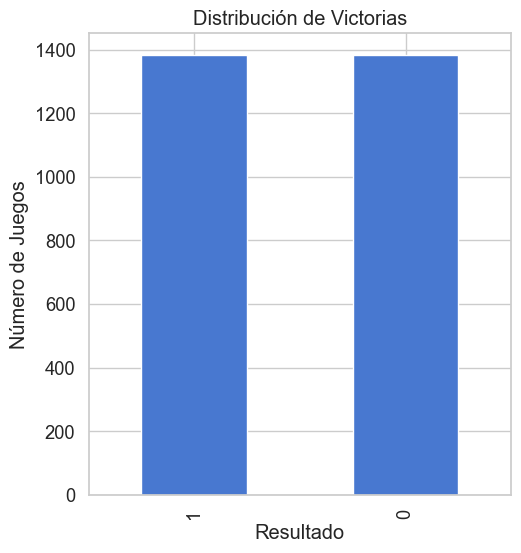

In [24]:
#grafico de victorias dan lo mismo pero para confirmar que no hay alguna variable mal
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
datos_limpios['GANO'].value_counts().plot(kind='bar')
plt.title('Distribuci\u00f3n de Victorias')
plt.xlabel('Resultado')
plt.ylabel('N\u00famero de Juegos')

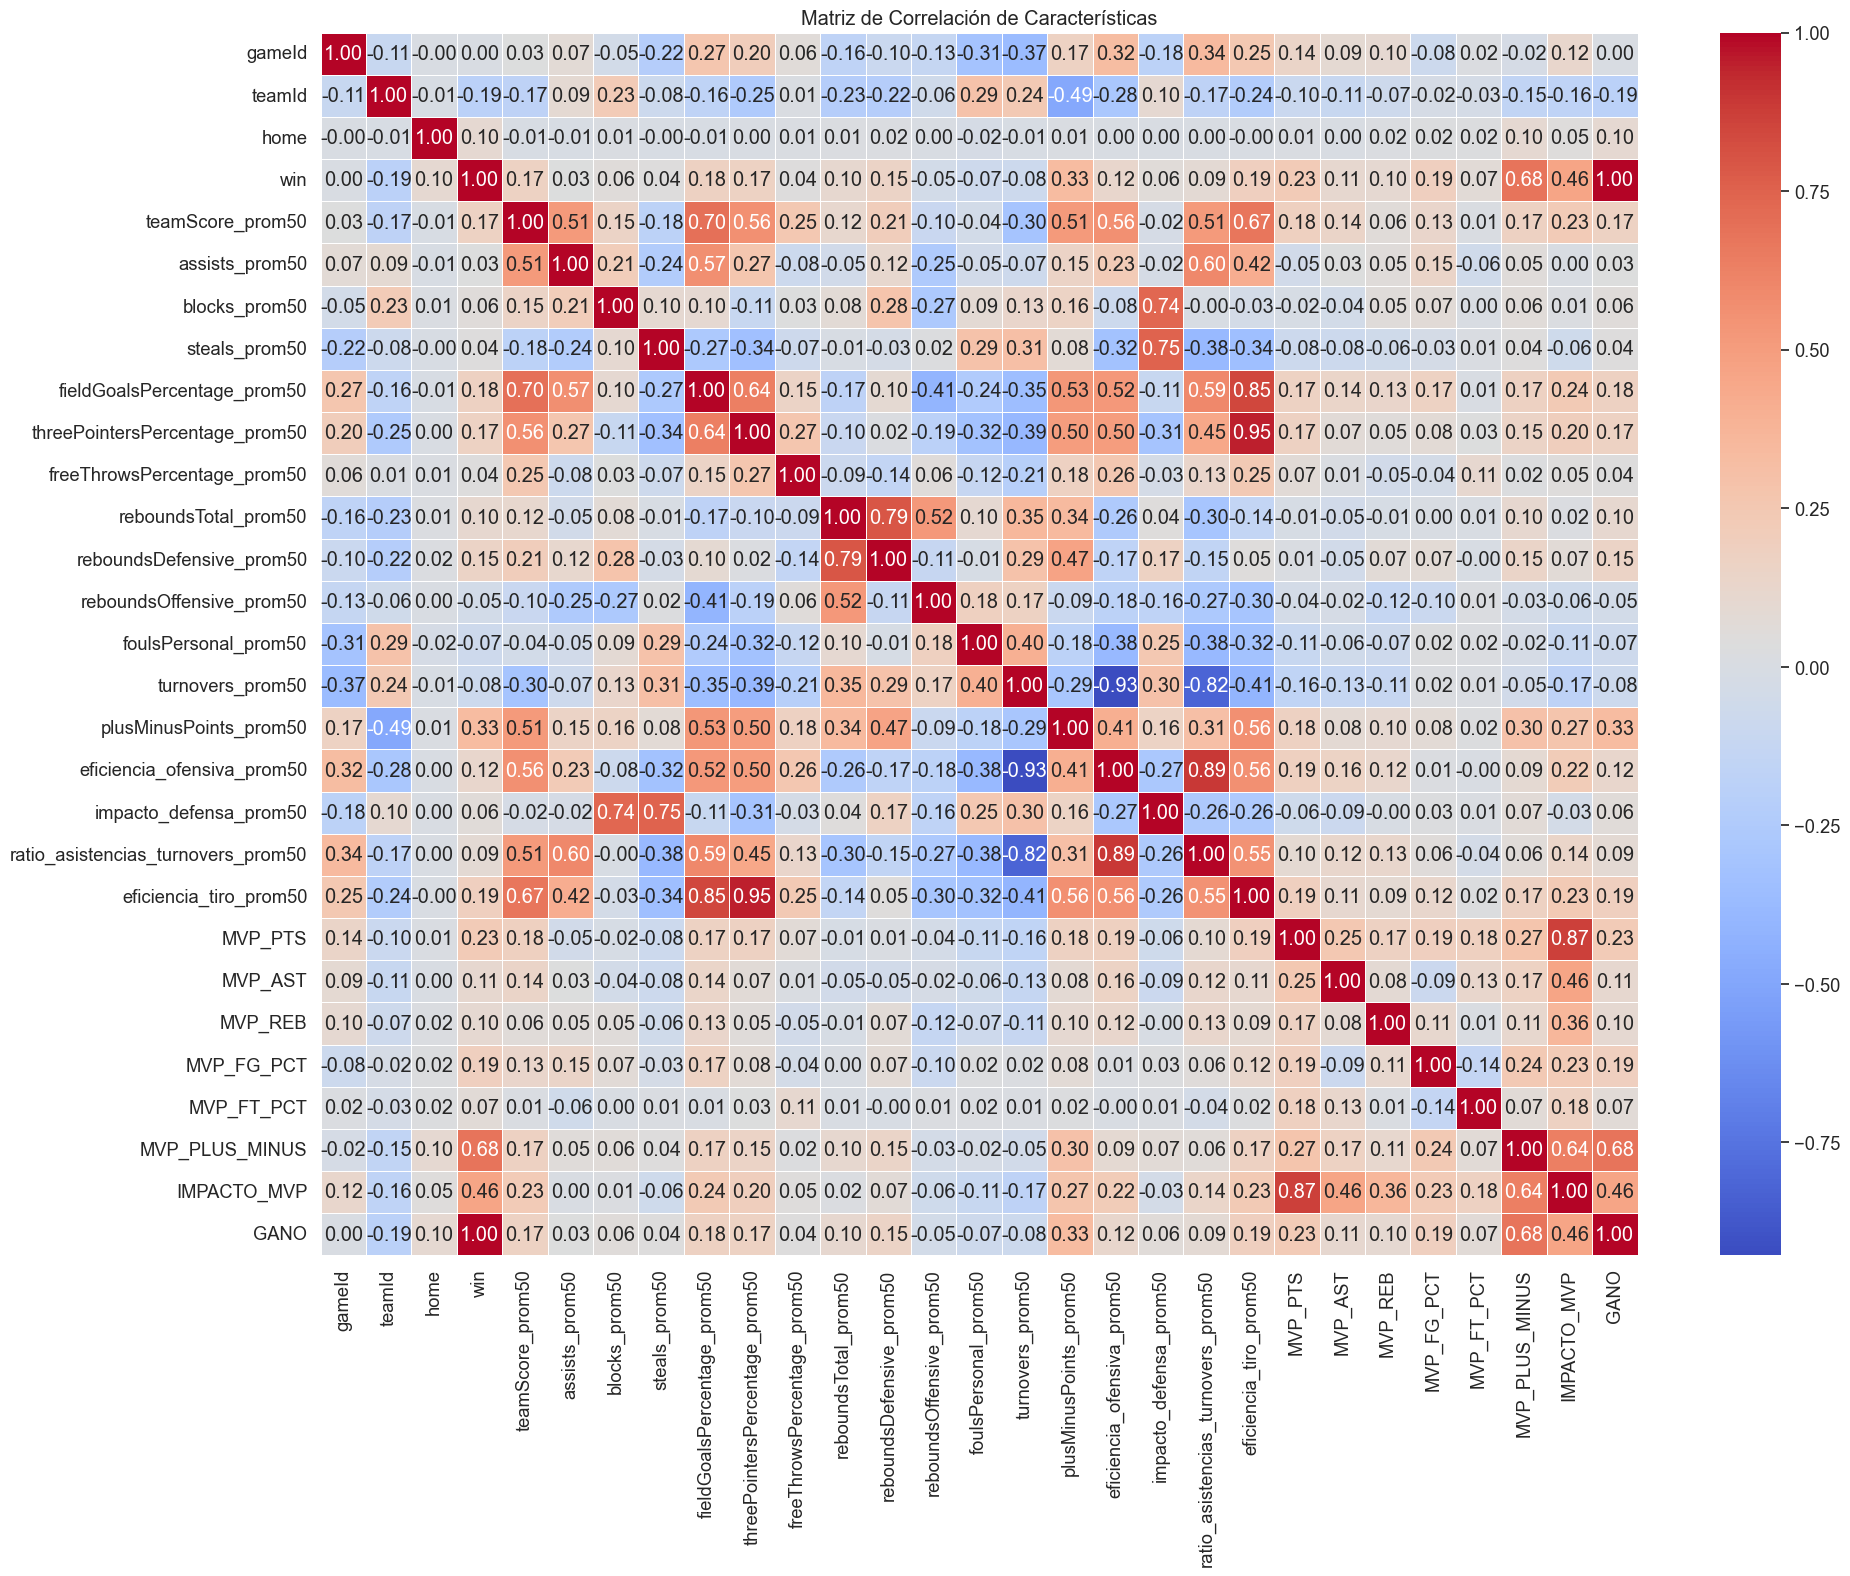

In [ ]:
# Matriz de correlación
plt.figure(figsize=(20, 16))
columnas_numericas = datos_limpios.select_dtypes(include=[np.number]).columns
matriz_correlacion = datos_limpios[columnas_numericas].corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Matriz de Correlación de Características')
plt.tight_layout()
plt.show()

In [26]:
#guarda en un csv y muestra la informacion ya de los datos limpios 
output_file = 'nba_cleaned_data_2024.csv'
datos_limpios.to_csv(output_file, index=False)
print(f"Datos limpios guardados en: {output_file}")
print("Número total de registros:", len(datos_limpios))
print("\nPrimeros registros:")
print(datos_limpios.head())

Datos limpios guardados en: nba_cleaned_data_2024.csv
Número total de registros: 2766

Primeros registros:
     gameId      teamId            gameDate  home  win  teamScore_prom50  \
0  12300015  1610612737 2023-10-10 19:30:00     1    1            108.00   
1  12300028  1610612737 2023-10-12 19:30:00     1    1            105.50   
2  12300035  1610612737 2023-10-14 15:30:00     1    1            107.00   
3  12300044  1610612737 2023-10-16 19:00:00     0    0            108.25   
4  12300068  1610612737 2023-10-20 19:00:00     0    0            107.80   

   assists_prom50  blocks_prom50  steals_prom50  fieldGoalsPercentage_prom50  \
0       22.000000       2.000000       9.000000                     0.435000   
1       25.500000       3.500000      12.500000                     0.437500   
2       26.333333       3.333333      13.333333                     0.450667   
3       24.750000       3.250000      11.250000                     0.458500   
4       25.800000       3.200000    

In [27]:
#mirar si algun valor nulo o NaN
print("\nNúmero de valores nulos por columna:")
print(datos_limpios.isnull().sum())
print(f"\nNúmero de filas duplicadas:  {datos_limpios.duplicated().sum()}")


Número de valores nulos por columna:
gameId                                0
teamId                                0
gameDate                              0
home                                  0
win                                   0
teamScore_prom50                      0
assists_prom50                        0
blocks_prom50                         0
steals_prom50                         0
fieldGoalsPercentage_prom50           0
threePointersPercentage_prom50        0
freeThrowsPercentage_prom50           0
reboundsTotal_prom50                  0
reboundsDefensive_prom50              0
reboundsOffensive_prom50              0
foulsPersonal_prom50                  0
turnovers_prom50                      0
plusMinusPoints_prom50                0
eficiencia_ofensiva_prom50            0
impacto_defensa_prom50                0
ratio_asistencias_turnovers_prom50    0
eficiencia_tiro_prom50                0
MVP_PTS                               0
MVP_AST                               0
MV

In [28]:
# Definimos las características para el modelo
caracteristicas = [
    'teamScore_prom50', 'assists_prom50', 'blocks_prom50', 'steals_prom50',
    'fieldGoalsPercentage_prom50', 'threePointersPercentage_prom50', 'freeThrowsPercentage_prom50',
    'reboundsTotal_prom50', 'plusMinusPoints_prom50',
    'eficiencia_ofensiva_prom50', 'impacto_defensa_prom50', 'ratio_asistencias_turnovers_prom50',
    'eficiencia_tiro_prom50',
    'MVP_PTS', 'MVP_AST', 'MVP_REB', 'MVP_FG_PCT',
    'IMPACTO_MVP', 'home'
]

In [ ]:
registros = []
#recorre cada id de los partidos de los datos limpios 
for game_id in datos_limpios['gameId'].drop_duplicates():
    #vuelve a recorrerlo para poder hacer el if
    equipos_juego = datos_limpios[datos_limpios['gameId'] == game_id]
    #si detecta que hay 2 lo hace es decir que hay dos equipos en el mismo partido
    if len(equipos_juego) == 2:
        # Simplemente tomamos el primer y segundo equipo del registro
        equipo1 = equipos_juego.iloc[0]
        equipo2 = equipos_juego.iloc[1]
        
        #resta las estadisticas para ver como se comparan
        entreno = equipo1[caracteristicas].values - equipo2[caracteristicas].values
        registros.append(np.append(entreno, int(equipo1['GANO'])))
        
        # Añadimos también el caso inverso para equilibrar el conjunto de datos
        entreno_inv = equipo2[caracteristicas].values - equipo1[caracteristicas].values
        registros.append(np.append(entreno_inv, int(equipo2['GANO'])))

In [30]:
#crea columnas par al dataset cambiando "entreno" + carateriticas
columnas_entreno = [f'entreno_{c}' for c in caracteristicas] + ['GANO']
#crea el dataset con registro y las columnas creadas 
data_entreno = pd.DataFrame(registros, columns=columnas_entreno)
print(f"Total de registros generados para enfrentamientos: {len(data_entreno)}")

Total de registros generados para enfrentamientos: 2766


In [31]:
# X todos las variables independientes 
X = data_entreno.drop(columns='GANO')
# Y va ser el target q buscamos
y = data_entreno['GANO']
#se pone la camntidad que se va utilizar de datos para entrenar y evaluar en este caso un 80 -20 y random poder quitar la aletoriedad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [32]:
#por si hay valores faltantes
imputo = SimpleImputer(strategy='median')
#mejorar escalado y rendimiento 
escalado = StandardScaler()

In [33]:
#calcula la media de cada columna .fit para aprender . tranform para aplicar
X_train_imp = imputo.fit_transform(X_train)
X_test_imp = imputo.transform(X_test)
#calcula la media y desviacion estandar de cada columna
X_train_esc = escalado.fit_transform(X_train_imp)
X_test_esc = escalado.transform(X_test_imp)

In [34]:
print(X_train.isnull().sum())

entreno_teamScore_prom50                      0
entreno_assists_prom50                        0
entreno_blocks_prom50                         0
entreno_steals_prom50                         0
entreno_fieldGoalsPercentage_prom50           0
entreno_threePointersPercentage_prom50        0
entreno_freeThrowsPercentage_prom50           0
entreno_reboundsTotal_prom50                  0
entreno_plusMinusPoints_prom50                0
entreno_eficiencia_ofensiva_prom50            0
entreno_impacto_defensa_prom50                0
entreno_ratio_asistencias_turnovers_prom50    0
entreno_eficiencia_tiro_prom50                0
entreno_MVP_PTS                               0
entreno_MVP_AST                               0
entreno_MVP_REB                               0
entreno_MVP_FG_PCT                            0
entreno_IMPACTO_MVP                           0
entreno_home                                  0
dtype: int64


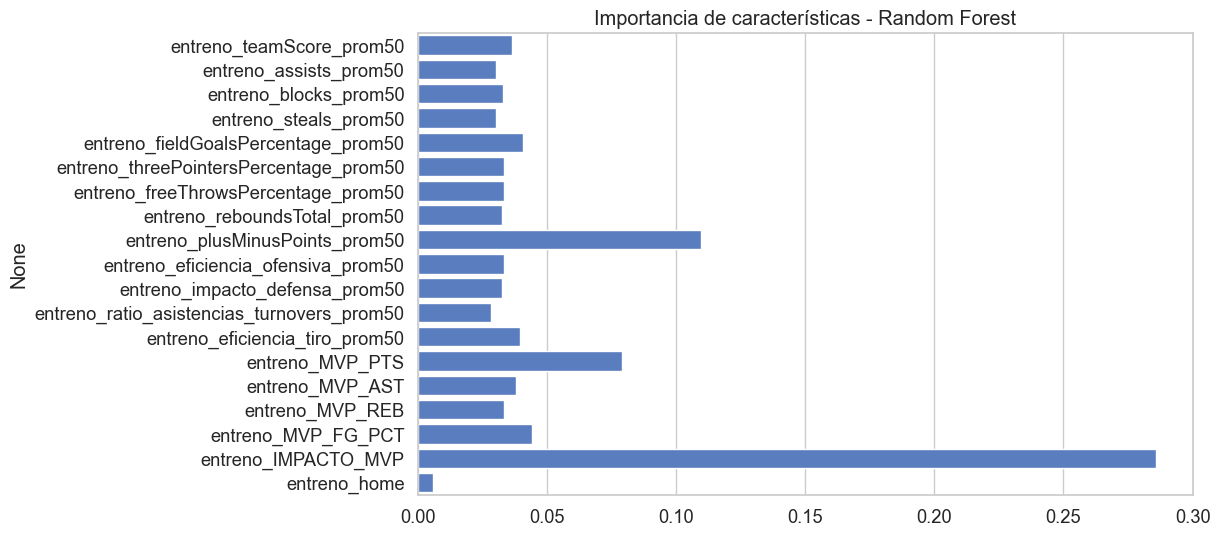

In [35]:
importances = RandomForestClassifier().fit(X_train_esc, y_train).feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=X.columns)
plt.title("Importancia de características - Random Forest")
plt.show()

In [36]:
parametros_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Voting': {
        'voting': ['soft'],
        'weights': [(1,1,1), (2,1,1), (1,2,1), (1,1,2)]
    }
}

In [37]:
# Definimos los modelos base
modelos_base = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42)
}

In [38]:
mejores_modelos = {}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
for nombre, modelo in modelos_base.items():
    print(f"\n{'='*50}")
    print(f"Optimizando hiperparámetros para: {nombre}")
    grid_search = GridSearchCV(
        estimator=modelo,
        param_grid=parametros_grids[nombre],
        cv=kfold,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_esc, y_train)
    
    # Guardamos el mejor modelo
    mejores_modelos[nombre] = grid_search.best_estimator_
    print(f"Mejor puntuación en validación: {grid_search.best_score_:.4f}")
    
    # Evaluamos en el conjunto de prueba
    y_pred = grid_search.predict(X_test_esc)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Precisión en conjunto de prueba: {test_acc:.4f}")
    
    # Mostramos informe de clasificación
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))


Optimizando hiperparámetros para: LogisticRegression
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor puntuación en validación: 0.8724
Precisión en conjunto de prueba: 0.8867

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       415
           1       0.89      0.89      0.89       415

    accuracy                           0.89       830
   macro avg       0.89      0.89      0.89       830
weighted avg       0.89      0.89      0.89       830


Optimizando hiperparámetros para: RandomForest
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejor puntuación en validación: 0.8115
Precisión en conjunto de prueba: 0.8108

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       415
           1       0.82      0.80      0.81       415

    accuracy                           0.81       830
   macro avg     

In [40]:
# Creamos un modelo de ensamble con los mejores modelos
mejores_estimadores = [(nombre, modelo) for nombre, modelo in mejores_modelos.items()]

voting_classifier = VotingClassifier(
    estimators=mejores_estimadores,
    voting='soft'
)

In [41]:
voting_classifier.fit(X_train_esc, y_train)
y_pred_voting = voting_classifier.predict(X_test_esc)
acc_voting = accuracy_score(y_test, y_pred_voting)

In [42]:
print("\n" + "="*50)
print(f"Precisión del modelo ensamblado: {acc_voting:.4f}")
print("\nInforme de clasificación del modelo ensamblado:")
print(classification_report(y_test, y_pred_voting))


Precisión del modelo ensamblado: 0.8747

Informe de clasificación del modelo ensamblado:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       415
           1       0.88      0.87      0.87       415

    accuracy                           0.87       830
   macro avg       0.87      0.87      0.87       830
weighted avg       0.87      0.87      0.87       830



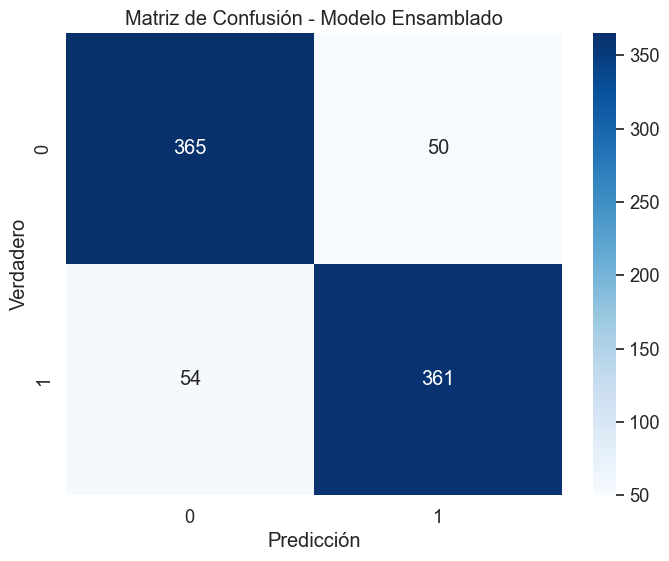

In [43]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo Ensamblado")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

In [44]:
# Comparamos el rendimiento de todos los modelos
resultados = []
for nombre, modelo in mejores_modelos.items():
    acc = modelo.score(X_test_esc, y_test)
    resultados.append((nombre, acc))

resultados.append(('Ensemble (Voting)', acc_voting))
resultados_df = pd.DataFrame(resultados, columns=["Modelo", "Precisión"])

print("\nComparación de Rendimiento de Modelos:")
print(resultados_df.sort_values('Precisión', ascending=False))


Comparación de Rendimiento de Modelos:
               Modelo  Precisión
0  LogisticRegression   0.886747
3                 SVM   0.879518
5   Ensemble (Voting)   0.874699
2    GradientBoosting   0.855422
4             XGBoost   0.850602
1        RandomForest   0.810843


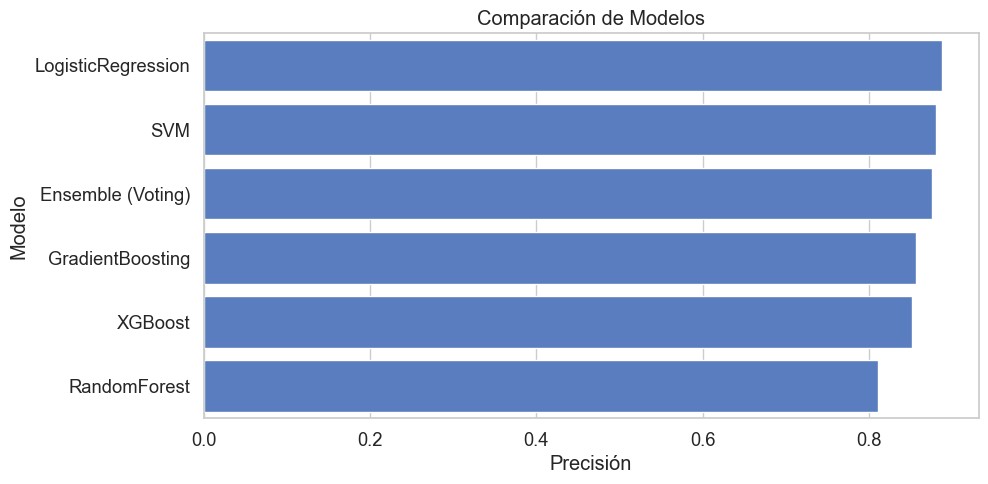

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Precisión', y='Modelo', data=resultados_df.sort_values('Precisión', ascending=False))
plt.title("Comparación de Modelos")
plt.xlabel("Precisión")
plt.ylabel("Modelo")
plt.show()

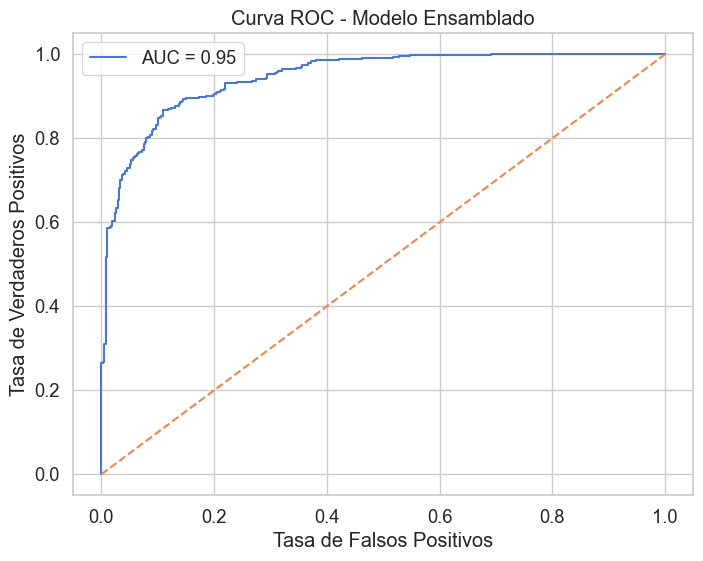

In [46]:
# Curva ROC
y_pred_prob = voting_classifier.predict_proba(X_test_esc)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("Curva ROC - Modelo Ensamblado")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.legend()
plt.show()

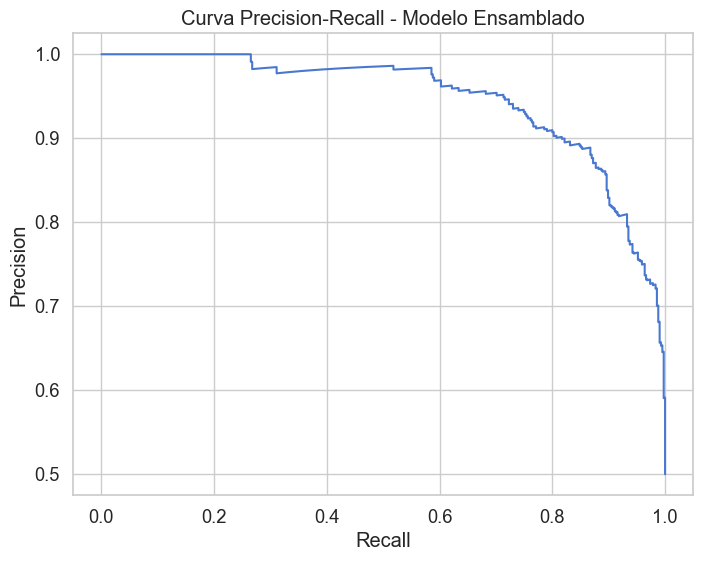

In [47]:
# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title("Curva Precision-Recall - Modelo Ensamblado")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [48]:
resultados_cv = []
for nombre, modelo in modelos_base.items():
    # Aplica validación cruzada con 5 particiones
    scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
    media = scores.mean()
    desviacion = scores.std()
    resultados_cv.append((nombre, media, desviacion))
    print(f"{nombre}: Precisión media = {media:.4f} (+/- {desviacion:.4f})")

LogisticRegression: Precisión media = 0.8778 (+/- 0.0100)
RandomForest: Precisión media = 0.8171 (+/- 0.0136)
GradientBoosting: Precisión media = 0.8474 (+/- 0.0163)
SVM: Precisión media = 0.8695 (+/- 0.0213)
XGBoost: Precisión media = 0.8503 (+/- 0.0077)


In [49]:
mejor_modelo_nombre = resultados_df.sort_values('Precisión', ascending=False).iloc[0]['Modelo']
mejor_modelo = mejores_modelos.get(mejor_modelo_nombre, voting_classifier)

print(f"\nModelo seleccionado para predicciones de enfrentamiento: {mejor_modelo_nombre}")


Modelo seleccionado para predicciones de enfrentamiento: LogisticRegression


In [50]:
#muestra equipos y su IDs
equipos_disponibles = equipos_2024[['teamId', 'teamName']].drop_duplicates().rename(columns={'teamId': 'TEAM_ID'})
print("\nEquipos disponibles para predicción:")
print(equipos_disponibles.sort_values('teamName').to_string(index=False))


Equipos disponibles para predicción:
   TEAM_ID      teamName
1610612755         76ers
1610612749         Bucks
1610612741         Bulls
1610612739     Cavaliers
1610612738       Celtics
1610612746      Clippers
1610612763     Grizzlies
1610612737         Hawks
1610612748          Heat
1610612766       Hornets
1610612762          Jazz
1610612758         Kings
1610612752        Knicks
1610612747        Lakers
1610612753         Magic
1610612742     Mavericks
1610612751          Nets
1610612743       Nuggets
1610612754        Pacers
1610612740      Pelicans
1610612765       Pistons
1610612761       Raptors
1610612745       Rockets
1610612759         Spurs
1610612756          Suns
1610612760       Thunder
1610612750  Timberwolves
1610612757 Trail Blazers
1610612744      Warriors
1610612764       Wizards


In [51]:
# Función para predicción con datos personalizados
def prediccion_futuro(datos_equipo1, datos_equipo2):
    # Validamos que tengamos todas las claves necesarias
    claves = [
        'teamScore_prom50', 'assists_prom50', 'blocks_prom50', 'steals_prom50',
        'fieldGoalsPercentage_prom50', 'threePointersPercentage_prom50', 'freeThrowsPercentage_prom50',
        'reboundsTotal_prom50', 'plusMinusPoints_prom50',
        'eficiencia_ofensiva_prom50', 'impacto_defensa_prom50', 'ratio_asistencias_turnovers_prom50',
        'eficiencia_tiro_prom50',
        'MVP_PTS', 'MVP_AST', 'MVP_REB', 'MVP_FG_PCT',
        'IMPACTO_MVP', 'home'
    ]
    
    # Verificamos si hemos recibido claves del formato anterior
    
    v1 = [datos_equipo1[clave] for clave in claves]
    v2 = [datos_equipo2[clave] for clave in claves]

    diff = np.array(v1) - np.array(v2)
    columnas_modelo = columnas_entreno[:-1]  # mismas que en el entrenamiento
    X_input = pd.DataFrame([diff], columns=columnas_modelo)
    X_imp = imputo.transform(X_input)
    X_esc = escalado.transform(X_imp)

    prob = mejor_modelo.predict_proba(X_esc)[0][1] * 100

    print(f"el modelo que se esta usando es: {mejor_modelo}")
    print(f"\n📊 Predicción: Local vs Visitante")
    print(f"Probabilidad de victoria del equipo local: {prob:.2f}%")
    return prob

In [52]:
datos_eq1 = {
    'teamScore_prom50': 118.5,
    'assists_prom50': 28.3,
    'blocks_prom50': 5.2,
    'steals_prom50': 7.1,
    'fieldGoalsPercentage_prom50': 0.48,
    'threePointersPercentage_prom50': 0.38,
    'freeThrowsPercentage_prom50': 0.81,
    'reboundsTotal_prom50': 43.1,
    'plusMinusPoints_prom50': 5.6,
    'eficiencia_ofensiva_prom50': 112.5,
    'impacto_defensa_prom50': 104.8,
    'ratio_asistencias_turnovers_prom50': 1.85,
    'eficiencia_tiro_prom50': 1.19,
    'MVP_PTS': 31,
    'MVP_AST': 8,
    'MVP_REB': 7,
    'MVP_FG_PCT': 0.52,
    'IMPACTO_MVP': 46,
    'diferencia_puntos': 2.3,
    'home': 1
}

datos_eq2 = {
    'teamScore_prom50': 115.2,
    'assists_prom50': 27.9,
    'blocks_prom50': 4.8,
    'steals_prom50': 6.7,
    'fieldGoalsPercentage_prom50': 0.46,
    'threePointersPercentage_prom50': 0.35,
    'freeThrowsPercentage_prom50': 0.78,
    'reboundsTotal_prom50': 44.0,
    'plusMinusPoints_prom50': 1.2,
    'eficiencia_ofensiva_prom50': 110.1,
    'impacto_defensa_prom50': 106.2,
    'ratio_asistencias_turnovers_prom50': 1.65,
    'eficiencia_tiro_prom50': 1.12,
    'MVP_PTS': 27,
    'MVP_AST': 6,
    'MVP_REB': 5,
    'MVP_FG_PCT': 0.48,
    'IMPACTO_MVP': 38,
    'diferencia_puntos': -1.5,
    'home': 0
}


prediccion_futuro(datos_eq1, datos_eq2)

el modelo que se esta usando es: LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

📊 Predicción: Local vs Visitante
Probabilidad de victoria del equipo local: 75.33%


np.float64(75.32548721304907)

In [ ]:
joblib.dump(voting_classifier, 'mejor_modelo.pkl')
joblib.dump(escalado, 'escalado_equipo.pkl')
joblib.dump(imputo, 'imputo_equipo.pkl')
print("\n✅ Modelos guardados correctamente.")


✅ Modelos guardados correctamente.
